In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

In [2]:
%pip install mne-qt-browser

import mne
print(mne.get_config())  # same as mne.get_config(key=None)
mne.set_config('MNE_BROWSER_BACKEND', 'qt')  # set the backend to matplotlib

   ---------------------------------------- 0.0/76.1 kB ? eta -:--:--
   ---------------------------------------- 76.1/76.1 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   --- ------------------------------------ 0.2/1.9 MB 4.6 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.9 MB 5.3 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/1.9 MB 5.3 MB/s eta 0:00:01
   ------------------- -------------------- 0.9/1.9 MB 5.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.2/1.9 MB 6.0 MB/s eta 0:00:01
   --------------------------------- ------ 1.6/1.9 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  1.9/1.9 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/871.8 kB ? eta -:--:--
   ------------------- ------------------- 440.3/871.8 kB 13.9 MB/s eta 0:00:01
   ---------------------

In [29]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}


Hello sinha
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_nocontext_day2.mat',

In [33]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt
import mne
import mne_connectivity
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue

        if rat_id=='dk3':
            continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)
        print(padd_ref_data, 'Reference electrode data padded to global start and end time')
        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        print(events_codes.shape, events_times.shape, 'Keyboard')
        print(events_codes)
        events_codes_all[base_name] = events_codes
        print(events_codes_all)
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        data_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        #print(all_channels)
        # Convert events_codes to strings for annotation descriptions
        annotation_descriptions = [str(code) for code in events_codes]
        annotations = mne.Annotations(onset=events_times, duration=np.zeros_like(events_times), description=annotation_descriptions)
        # Remove any keys from keyboard_dict that are not present in annotation_descriptions
        present_keys = set(annotation_descriptions) & set(keyboard_dict.keys())
        filtered_keyboard_dict = {k: v for k, v in keyboard_dict.items() if k in present_keys}
        if len(filtered_keyboard_dict) < len(keyboard_dict):
            print(f"Filtered keyboard_dict to only present annotation descriptions: {filtered_keyboard_dict}")
        if filtered_keyboard_dict:
            annotations.rename(filtered_keyboard_dict)
        else:
            print("No matching annotation descriptions found for renaming.")
        
        all_channels = list(data_channels) + ['reference']
        info = mne.create_info(ch_names=list(all_channels), sfreq=2000, ch_types='eeg')

        all_channels_data= []

        first_event = events_times[0]
        raw_data = []
        for channel_num,channeli in enumerate(data_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()

                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,2000)

                print(len(padded_data), len(padded_data), channel_id)
                all_channels_data.append(padded_data)
            
        all_channels_data = np.array(all_channels_data)
        all_channels_data = np.vstack((all_channels_data, padd_ref_data))
        print(all_channels_data.shape)
        mne_all_channels_data = mne.io.RawArray(all_channels_data, info)
        print(mne_all_channels_data.info)
        mne_all_channels_data.set_eeg_reference(ref_channels=['reference'], projection=False, ch_type='eeg')
        mne_all_channels_data.set_annotations(annotations)
#mne.viz.plot_raw(mne_all_channels_data, duration=60, scalings='auto', show=True, block=True)
        all_data_epochs= mne.Epochs(mne_all_channels_data, events=None, event_id=None, tmin=-0.7, tmax=0.7, baseline=None, preload=True, verbose=True, event_repeated='drop')
        row= [file_num, rat_id, task, all_data_epochs]
        event_data_df.append(row)
event_data_df=pd.DataFrame(event_data_df, columns=['experiment','rat_id','task','epochs'])
print(event_data_df)

#                 sampling_rate = int(1 / data_all['interval'][0][0])
#                 #print(raw_data.shape, raw_time.shape, sampling_rate)
#                 subtracted_data = padded_data - padd_ref_data
#                 raw_data=subtracted_data
#                 notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)

#                 data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
#                 first_event_index=np.where(raw_time>first_event)[0][0]

#                 mne_baseline_data[0,channel_num,:]=list(data_before)
#                 mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
#                 total = notch_filtered_data

                
#                 for i, epochi in enumerate(epochs):
#                     door_timestamp = epochi[0][0]
#                     trial_type = epochi[0][1]
#                     dig_type = epochi[1, 1]
#                     #print(dig_type)
#                     dig_timestamp = epochi[1, 0]
#                     #print(door_timestamp, trial_type, dig_timestamp, dig_type)
#                     data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,0.7)
#                     data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,0.7)
#                     data_around_door=np.concatenate((data_trial_before, data_trial_after))
#                     data_around_dig=np.concatenate((data_dig_before, data_dig_after))

#                     epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
#                     event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

#                     mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
#                     mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
#                     mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
#                     mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
#                     mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4])
#                     mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5])

#                     mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0]))
#                     mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1]))
#                     mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2]))
#                     mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3]))
#                     mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4]))
#                     mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5]))

#         if len(all_channels)>0:
#             fs=2000
#             freqs = np.arange(1,100)
#             n_cycles = freqs/3
#             info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
#             mne_baseline = mne.EpochsArray(mne_baseline_data, info)
#             mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
#             mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
#             mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
#             mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
#             mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
#             mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
            
#             row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
#             mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
#             mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
#             mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
#             mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
#             mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
#             mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
#             mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
#             row_list_shuffled=[file_num,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
#             shuffled_event_data_df.append(row_list_shuffled)

#             con_data_df.append(row_list)
#             con_data_df_shuffled.append(row_list_shuffled)


# con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
# con_data_df.to_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

# con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
# con_data_df_shuffled.to_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')


20230529 dk1 nocontext
20230529 dk3 nocontext
20230529 dk5 nocontext
20230529 dk6 nocontext
20230531 dk1 nocontextday2
20230531 dk3 nocontextday2
20230531 dk5 nocontextday2
20230531 dk6 nocontextday2
20230609 dk1 BWnocontext
['LFP1_vHp', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Memory', 'Ref', 'Respirat', 'file']
[-0.12893677 -0.1121521  -0.08834839 ... -0.03677368 -0.03936768
  0.        ] Reference electrode data padded to global start and end time
(85,) (85,) Keyboard
[ 98  48  49  98  49  98  49 119   1  98  49 119  49  98  49 119  49 119
  49  98  49 119  49 119  49 119  49 119  49  98  49  98  49  98  49 119
  49  98  49  98  49  98  48  49 119  49 119  49 119  49 119  49  98  49
  98  49  98  49 119  49 119  49 119  49  98  49 119  49 119  49 119  48
  49  98  49  98  48  49 119  49 119  49 119  48  49]
{'20230609_dk1_BW_nocontext_day1': array([ 98,  48,  49,  98,  49,  98,  49, 119,   1,  98,  49, 119,  49,
        98,  49, 119,  49, 119,  49,  98,  49, 119,  49, 119,  49, 119,
   

In [ ]:
all_data_epochs.plot(n_epochs=10, events=True)

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [19]:
all_data_epochs["1"].plot_image(combine="mean", colorbar=True, show=True)

RuntimeError: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


C:\Users\sinha\AppData\Local\Temp\ipykernel_27520\2679778123.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  all_data_epochs["1"].plot_psd(fmin=4, fmax=100, method='multitaper', show=True, picks=data_channels, spatial_colors=True)


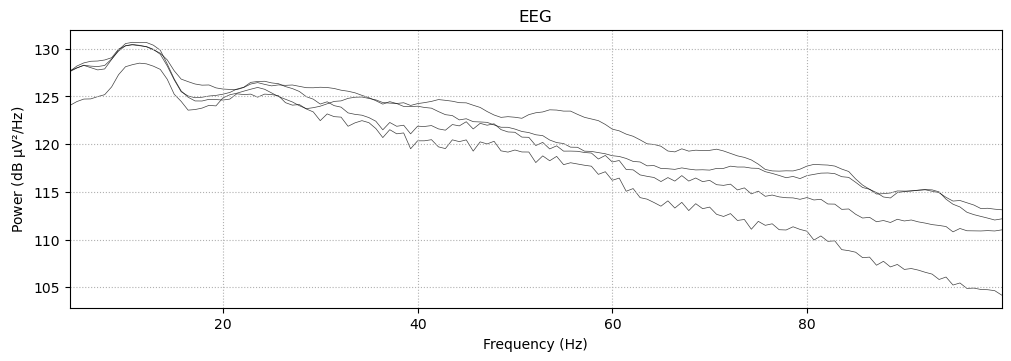

In [27]:
all_data_epochs["1"].plot_psd(fmin=4, fmax=100, method='multitaper', show=True, picks=data_channels, spatial_colors=True)